### Resources:
* [D-separation steps](http://web.mit.edu/jmn/www/6.034/d-separation.pdf)
* [bnlearn datasets](https://www.bnlearn.com/bnrepository/)
* [Daggity paper](https://academic.oup.com/ije/article/45/6/1887/2907796)
* [Milestone](https://gitlab.pnnl.gov/y0-scuc/y0-archive/-/milestones/4)
* [pgmpy](https://github.com/pgmpy/pgmpy/blob/dev/examples/Creating%20a%20Discrete%20Bayesian%20Network.ipynb)  -- get_independencies

### TODO:
* Break into module, write proper unit tests
* What about conditional independencies?  Currently only covers independencies.  
   * Can I just enumerate tripples and check 'A,B given=["C"]'?  
   * Would then check combinations-pairs + combinations-givens 
   * Up to how many givens do you check?

In [1]:
from y0.algorithm import falsification
from y0.graph import ADMG
import y0.examples
from y0.dsl import Variable

import networkx as nx
import pandas as pd

import seaborn as sns
from itertools import chain
from tqdm import tqdm

%matplotlib inline

%load_ext autoreload
%autoreload 2

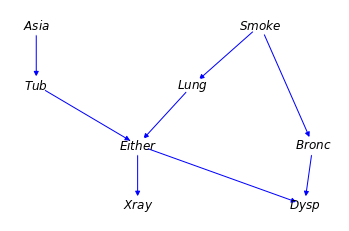

In [2]:
asia_G = y0.examples.asia_example.graph  # .to_admg()
asia_df = y0.examples.asia_example.data

asia_G.draw()

In [3]:
asia_df

Unnamed: 0  Asia  Smoke  Tub  Lung  Bronc  Either  Xray  Dysp
0              1    -1      1   -1    -1      1      -1    -1     1
1              2    -1      1   -1    -1     -1      -1    -1    -1
2              3    -1     -1    1    -1     -1       1     1     1
3              4    -1     -1   -1    -1      1      -1    -1     1
4              5    -1     -1   -1    -1     -1      -1    -1     1
...          ...   ...    ...  ...   ...    ...     ...   ...   ...
4995        4996    -1     -1   -1    -1      1      -1     1     1
4996        4997    -1     -1   -1    -1     -1      -1    -1    -1
4997        4998    -1     -1   -1    -1     -1      -1    -1    -1
4998        4999    -1      1   -1    -1     -1      -1    -1     1
4999        5000    -1      1   -1    -1      1      -1    -1     1

[5000 rows x 9 columns]

In [8]:
issues = falsification.get_graph_falsifications(asia_G, asia_df, max_given=2, verbose=True)

d-separation check: 28it [00:00, 288.93it/s]
Checking conditionals: 100%|██████████| 17/17 [00:00<00:00, 162.72it/s]


In [9]:
issues.evidence

left   right   given     chi^2  p       dof  Holm–Bonferroni level  \
0     Lung    Xray  Either  0.000000  1  1.000000               0.002778   
13  Either   Smoke    Lung  0.000000  1  1.000000               0.010000   
12   Smoke     Tub          0.000000  1  1.000000               0.008333   
5      Tub    Xray  Either  0.000000  1  1.000000               0.003846   
11   Smoke    Xray    Lung  0.278697  2  0.869925               0.007143   
15    Dysp    Xray  Either  0.617808  2  0.734251               0.016667   
10    Lung     Tub          0.129525  1  0.718925               0.006250   
16   Bronc    Xray    Lung  0.697125  2  0.705702               0.025000   
2     Asia    Lung          0.201322  1  0.653656               0.003125   
14    Asia  Either     Tub  0.300140  1  0.583795               0.012500   
8     Asia    Xray     Tub  0.413105  1  0.520398               0.005000   
7     Asia    Dysp     Tub  1.471978  2  0.479031               0.004545   
9    Bronc  Either    Lung  1.206968  1  0.271933               0.005556   
3    Bronc    Lung   Smoke  3.477138  2  0.175772               0.003333   
1     Asia   Smoke          1.841060  1  0.174827               0.002941   
4    Bronc     Tub          2.364399  1  0.124132               0.003571   
6     Asia   Bronc          2.495844  1  0.114147               0.004167   

    flagged  
0     False  
13    False  
12    False  
5     False  
11    False  
15    False  
10    False  
16    False  
2     False  
14    False  
8     False  
7     False  
9     False  
3     False  
1     False  
4     False  
6     False

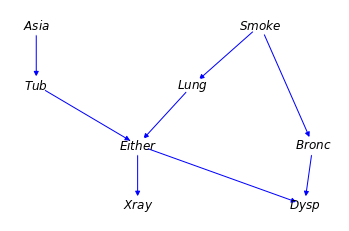

In [19]:
# Should be issues (Lung, Either) AT LEAST.
# .  Seeing issues (Lung, Xray) as well.  Is that all?
# TODO: Check d-separations by hand...
import copy

asia_G2 = copy.deepcopy(asia_G)
asia_G2.draw()

In [20]:
asia_G2.directed.remove_edge(
    Variable("Lung"), Variable("Either")
)  # delete_diedge("Lung", "Either")
issues = falsification.get_graph_falsifications(asia_G2, asia_df)
issues.failures

Series([], dtype: float64)

In [28]:
issues.evidence

left   right      given        chi^2             p  dof  \
19    Dysp    Lung   (Smoke,)    83.247571  0.000000e+00    2   
15    Dysp   Smoke   (Bronc,)    21.128858  2.581824e-05    2   
3     Lung    Xray         ()  2094.106838  0.000000e+00    1   
4   Either    Lung         ()  3099.534805  0.000000e+00    1   
20  Either   Smoke         ()   196.335994  1.316547e-44    1   
17   Smoke    Xray         ()   127.464729  1.469901e-29    1   
10   Bronc  Either         ()    22.547558  2.050050e-06    1   
0    Bronc    Xray         ()    14.983980  1.084278e-04    1   
18    Asia    Xray  (Either,)     4.268355  1.183419e-01    2   
9    Bronc    Lung   (Smoke,)     3.477138  1.757718e-01    2   
2     Asia    Dysp  (Either,)     1.243757  5.369350e-01    2   
7     Dysp    Xray  (Either,)     0.656339  7.202409e-01    2   
6     Asia   Bronc         ()     2.495844  1.141472e-01    1   
13   Bronc     Tub         ()     2.364399  1.241317e-01    1   
12    Asia   Smoke         ()     1.841060  1.748268e-01    1   
1      Tub    Xray  (Either,)     0.303830  5.814912e-01    1   
11    Asia  Either     (Tub,)     0.300140  5.837949e-01    1   
8     Asia    Lung         ()     0.201322  6.536561e-01    1   
14    Lung     Tub         ()     0.129525  7.189249e-01    1   
5    Smoke     Tub         ()     0.012421  9.112584e-01    1   
16    Dysp     Tub  (Either,)     0.000636  9.798753e-01    1   

    Holm–Bonferroni level  flagged  
19               0.016667     True  
15               0.007143     True  
3                0.002632     True  
4                0.002778     True  
20               0.025000     True  
17               0.010000     True  
10               0.004167     True  
0                0.002273     True  
18               0.012500    False  
9                0.003846    False  
2                0.002500    False  
7                0.003333    False  
6                0.003125    False  
13               0.005556    False  
12               0.005000    False  
1                0.002381    False  
11               0.004545    False  
8                0.003571    False  
14               0.006250    False  
5                0.002941    False  
16               0.008333    False

In [21]:
issues

Falsifications(failures=Series([], dtype: float64), evidence=      left   right   given        chi^2  p           dof  \
15     Tub    Xray  Either     0.000000  1  1.000000e+00   
5    Smoke     Tub             0.000000  1  1.000000e+00   
4     Dysp     Tub  Either     0.000000  1  1.000000e+00   
19    Dysp    Xray  Either     0.617808  2  7.342514e-01   
3     Lung     Tub             0.129525  1  7.189249e-01   
1     Asia    Lung             0.201322  1  6.536561e-01   
14    Asia  Either     Tub     0.300140  1  5.837949e-01   
9     Asia    Xray     Tub     0.413105  1  5.203979e-01   
18    Asia    Dysp     Tub     1.471978  2  4.790315e-01   
12   Bronc    Lung   Smoke     3.477138  2  1.757718e-01   
11    Asia   Smoke             1.841060  1  1.748268e-01   
13   Bronc     Tub             2.364399  1  1.241317e-01   
2     Asia   Bronc             2.495844  1  1.141472e-01   
16   Bronc    Xray            14.983980  1  1.084278e-04   
8     Dysp   Smoke   Bronc    21.128858